In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import cm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D


from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [3]:
sns.set_style("darkgrid")
sns.set_context("talk")

from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [4]:
SYNTHETIC_DATASETS = ["gestalt_shapegen", "tdw", "hypersim_v2", "hypersim_v3"]

In [5]:
projName = "mlve"
dataset = "nsd"
experimentName = f"{dataset}-segmentation"
S3_BUCKET_NAME = "mlve-v1"
iterName = "v2-all"

In [6]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

def results_to_df(max_limit=-1):
    results = []
    cursor = col.find({})
    count = 0
    for document in cursor:
        results.append(document)
        count += 1
        if max_limit > -1 and count == max_limit:
            break
    
    print(f"Returning {count} total records" )
    df = pd.DataFrame(results)
    return df

df = results_to_df()

Checking database connection...
Connection established!
Returning 127 total records


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      0 non-null      object 
 1   imageMetadata            0 non-null      object 
 2   imageURL                 0 non-null      object 
 3   attentionCheck           0 non-null      object 
 4   sameObj                  0 non-null      object 
 5   probeIDs                 0 non-null      object 
 6   correct_segmentation     0 non-null      float64
 7   probeLocations           0 non-null      object 
 8   isDuplicate              0 non-null      object 
 9   batchIdx                 0 non-null      float64
 10  rt                       0 non-null      float64
 11  index                    0 non-null      float64
 12  stimulus                 0 non-null      object 
 13  segmentation_response    0 non-null      float64
 14  depth_response           0 non-null   

In [8]:
for i, x in df[df["trial_type"] == "survey-text"].iterrows():
    if x["response"]["Q0"]:
        print(x["response"], x["userID"])

In [9]:
# drop reviews
df = df.drop(df.loc[df["trial_type"] != "plugin-depth-task"].index.tolist())

In [10]:
def filter_attention_check_fails(df, key="correct", threshold=0.5, remove_attention_trials=True):
    att_checks = df.loc[df["attentionCheck"] == True]
    failed_checks = att_checks.groupby("userID")[key].mean() < threshold
    participants_failed = [failed_checks.keys()[i] for i in range(len(failed_checks)) if failed_checks[i]]
    if remove_attention_trials:
        drop_rows = att_checks.index.tolist()
        temp_df = df.drop(drop_rows)
        
        return participants_failed, temp_df
    
    return participants_failed, df

def drop_users(df, user_list):
    drop_rows = df.loc[df["userID"].isin(user_list) == True].index.tolist()
    print(len(drop_rows))
    new_df = df.drop(drop_rows)
    return new_df

In [14]:
failed_users, df = filter_attention_check_fails(df, key="segmentation_correct")
user_results = df.groupby("userID")["segmentation_correct"].mean()

for fail in failed_users:
    print(f"Participant ID failed attention checks: {fail}, Overall score: {user_results[fail]}")
    
df = drop_users(df, failed_users)

0


In [17]:
df["stimulus"

Series([], Name: stimulus, dtype: object)

In [ ]:
stimulus_means = df.groupby("stimulus")["correct"].mean()

KeyError: 'Column not found: correct'

In [98]:
def random_hex():
    r = lambda: np.random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

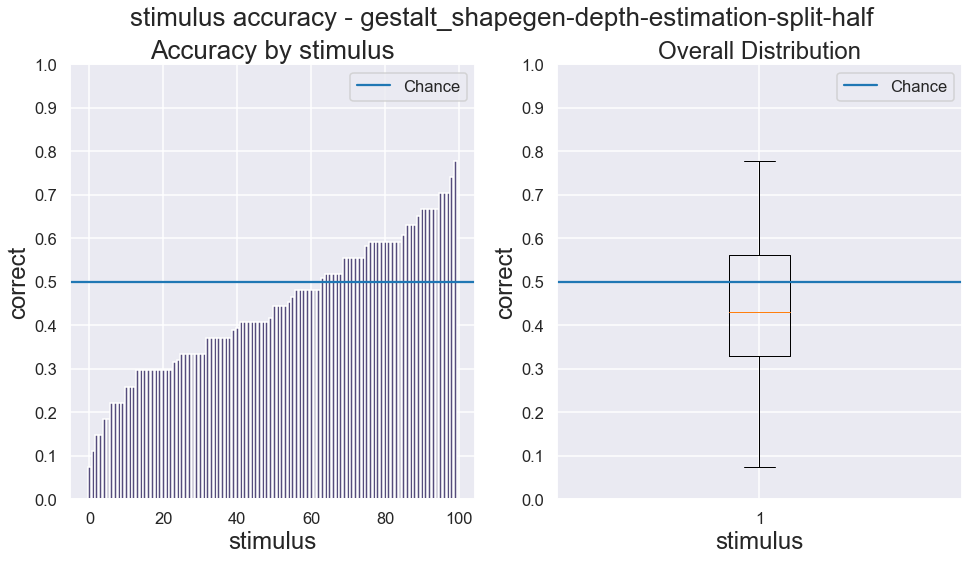

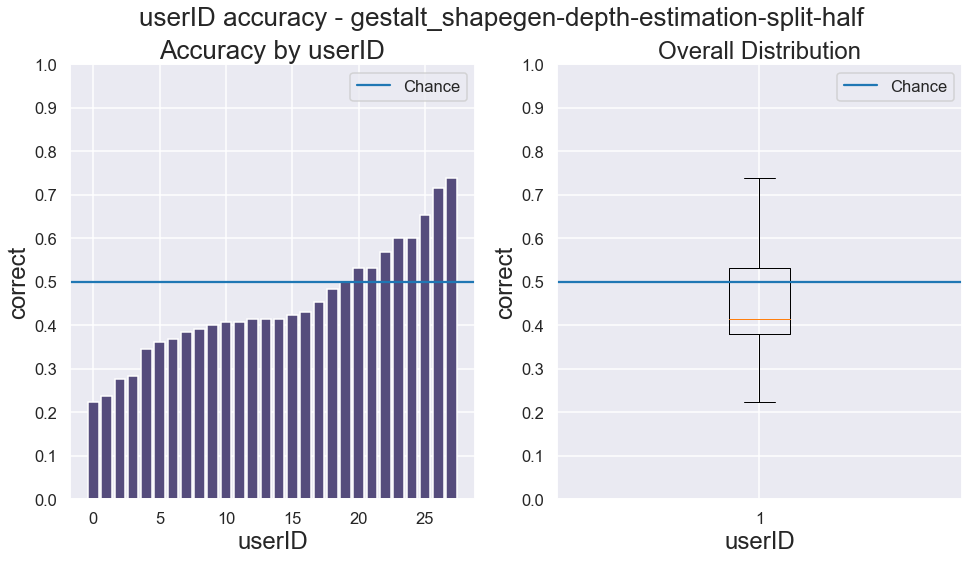

In [99]:
def plot_distributions(df, population="stimulus", target="correct", color="random"):
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    pop = df.groupby(population)[target].mean()
    sorted_pop_means = pop.sort_values()
    ax1.bar(range(len(pop)), sorted_pop_means, color=color)
    ax1.set_xlabel(population, fontsize=24)
    ax1.set_ylabel(target, fontsize=24)
    ax1.set_yticks(np.arange(0, 1.1, .1))
    ax1.axhline(y=0.5, label="Chance")
    ax1.set_ylim(0, 1)
    ax1.legend()
    
    ax2.boxplot(pop)
    ax2.set_xlabel(population, fontsize=24)
    ax2.set_ylabel(target, fontsize=24)
    ax2.set_yticks(np.arange(0, 1.1, .1))
    ax2.set_ylim(0, 1)
    
    ax1.set_title(f"Accuracy by {population}", fontsize=26)
    ax2.set_title("Overall Distribution", fontsize=24)
    plt.suptitle(f"{population} accuracy - {experimentName}")
    
    plt.axhline(y=0.5, label="Chance")
    plt.legend()
    plt.show()

if dataset in SYNTHETIC_DATASETS:
    color = random_hex()
    plot_distributions(df, population="stimulus", color=color)
    plot_distributions(df, population="userID", color=color)


In [100]:
def l2_dist(x1, x2):
    diffs = [(x1[0] - x2[0]) ** 2, (x1[1] - x2[1]) ** 2]
    return np.sqrt(np.sum(diffs))

def l1_dist(x1, x2):
    diffs = [np.abs(x1[0] - x2[0]), np.abs(x1[1] - x2[1])]
    return np.sqrt(np.sum(diffs))

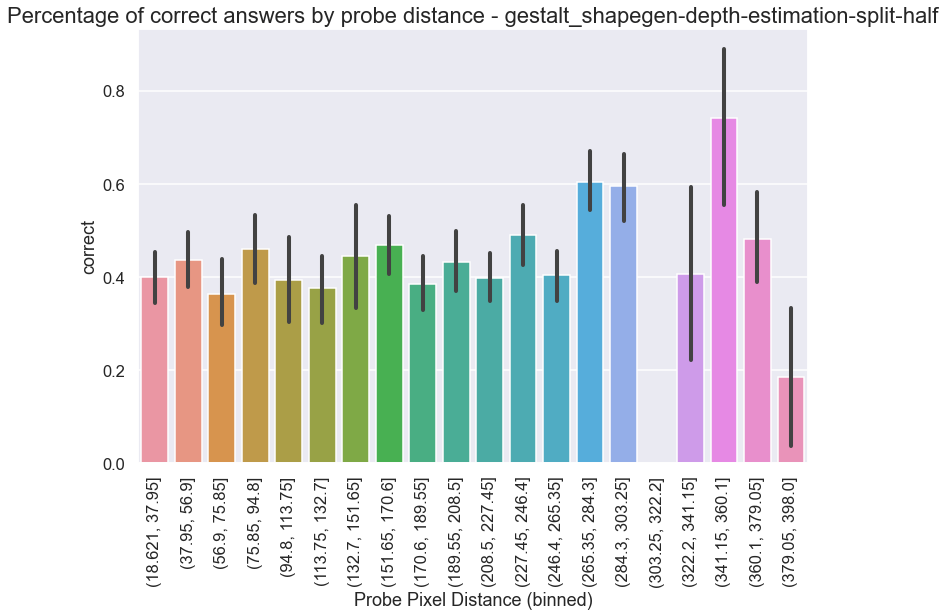

In [101]:
df["probe_distance"] = df["probe_locations"].apply(lambda x: l2_dist(x[0], x[1]))

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=pd.cut(df["probe_distance"], 20), y=df["correct"])
plt.xlabel("Probe Pixel Distance (binned)")
plt.xticks(range(20), rotation=90)
plt.title(f"Percentage of correct answers by probe distance - {experimentName}", fontsize=22)
plt.show()

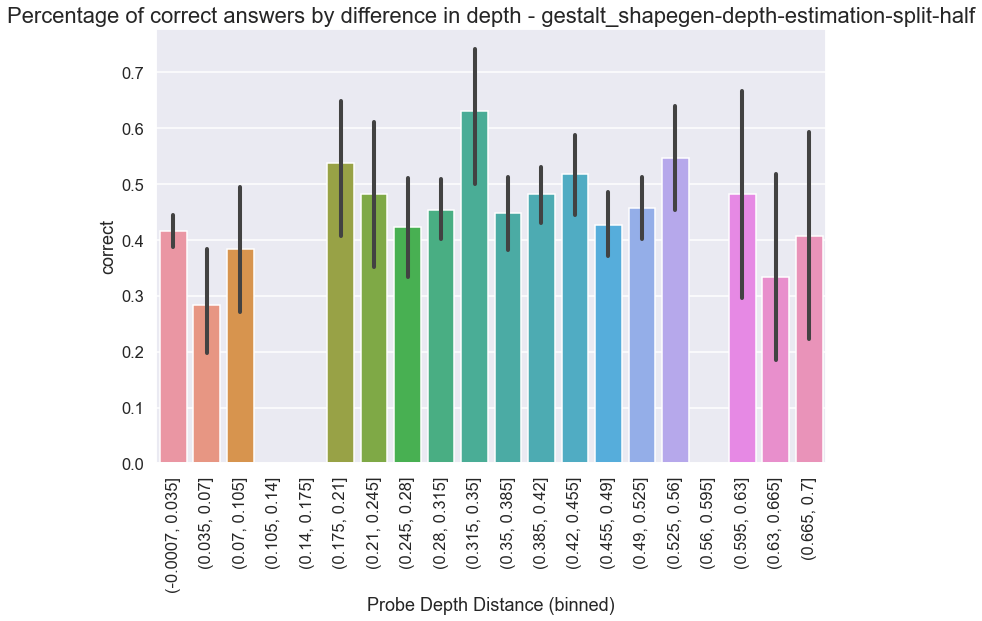

In [102]:
def replace(l, v1, v2):
    """
    replace all values (`v1`) with `v2` in a list `l` 
    """
    for i in range(len(l)):
        if l[i] == v1:
            l[i] = v2
    return l

if dataset in SYNTHETIC_DATASETS:
    df["gtDepths"] = df["gtDepths"].apply(lambda x: replace(x, None, 1))
    df["depth_distance"] = df["gtDepths"].apply(lambda x: np.sqrt((x[0] - x[1]) ** 2))
    fig, ax = plt.subplots(figsize=(12,8))
    sns.barplot(x=pd.cut(df["depth_distance"], 20), y=df["correct"])
    plt.xlabel("Probe Depth Distance (binned)")
    plt.xticks(range(20), rotation=90)
    plt.title(f"Percentage of correct answers by difference in depth - {experimentName}", fontsize=22)
    plt.show()

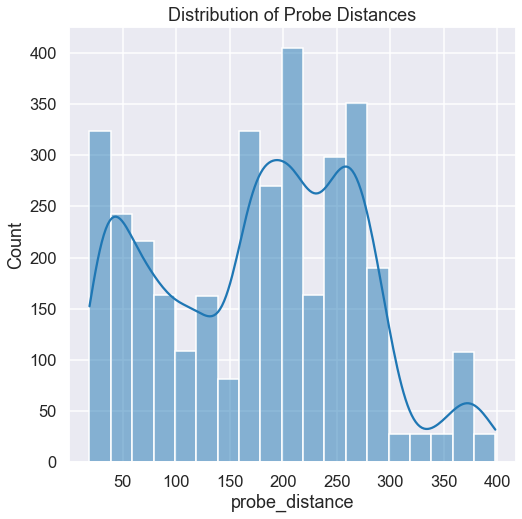

In [103]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df["probe_distance"], kde=True, ax=ax)
plt.title("Distribution of Probe Distances")
plt.show()

In [104]:
def simple_regplot(
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)

    return fit_results

Resulting parameters: 
------------------------------
const             0.161190
probe_distance    0.000525
dtype: float64


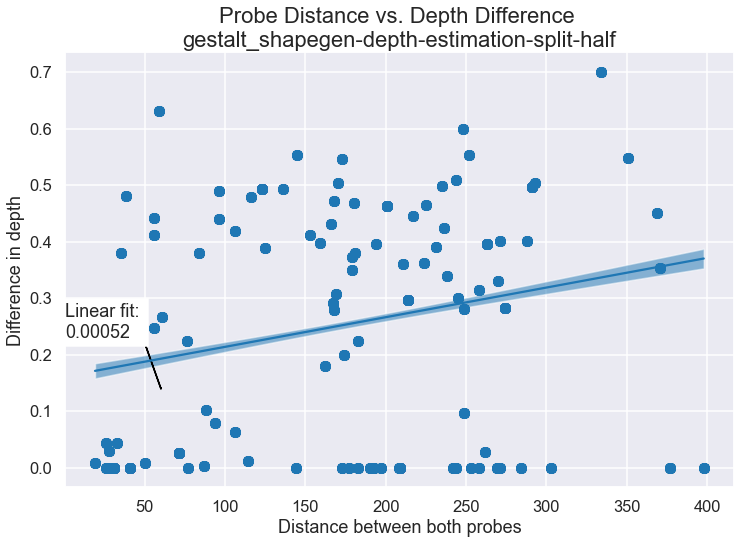

In [105]:
if dataset in SYNTHETIC_DATASETS:
    fig, ax = plt.subplots(figsize=(12, 8))


    fit_result = simple_regplot(df["probe_distance"], df["depth_distance"], ax=ax)
    print("Resulting parameters: \n------------------------------")
    print(fit_result.params)
    plt.title(f"Probe Distance vs. Depth Difference \n{experimentName}", fontsize=22)
    plt.xlabel("Distance between both probes")
    plt.ylabel("Difference in depth")

    plt.text(0.23, 0.23, f"Linear fit: \n{fit_result.params[1]:0.5f}", backgroundcolor="white")
    plt.arrow(50, 0.22, 10, -.08, color="black", )
    plt.show()

analysis to-do:

1. Inter-subject reliability (check consistency between repeats)
2. Check noise ceiling for individual points
3. Check worst trials -- see what the deal is
4. Look at distribution of answers

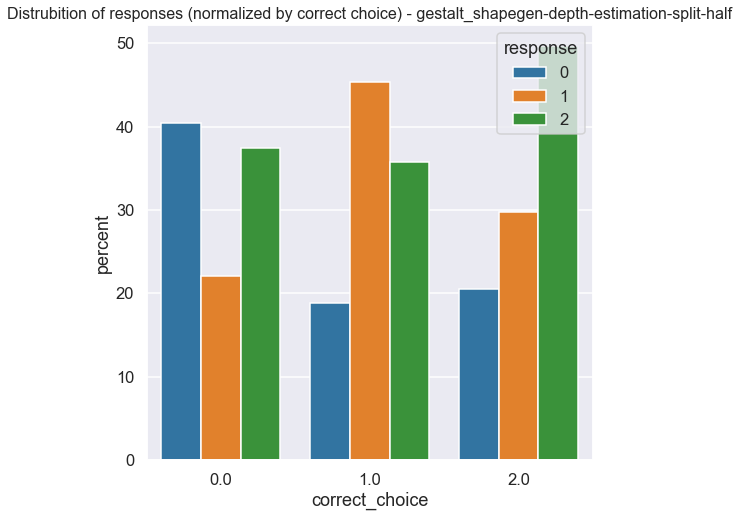

In [106]:
x="correct_choice"
y="response"

fig, ax = plt.subplots(figsize=(8, 8))
(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x=x,y='percent',hue=y, ax=ax))

plt.title(f"Distrubition of responses (normalized by correct choice) - {experimentName}", fontsize=16)
plt.show()


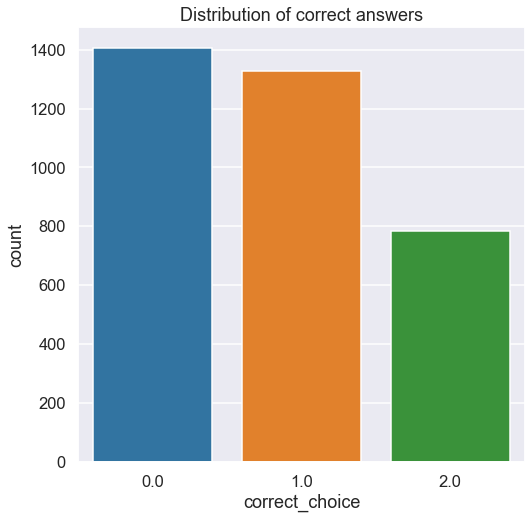

In [107]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x=df["correct_choice"], ax=ax)
plt.title("Distribution of correct answers")
plt.show()

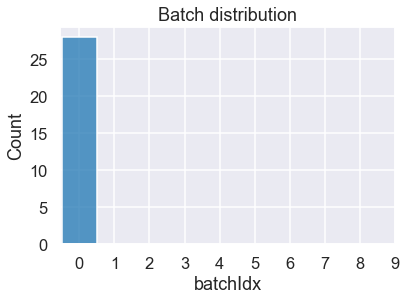

In [108]:
batch_counts = df.groupby("userID")["batchIdx"].mean() # sort of hacky way to get per-
sns.histplot(x=batch_counts, stat="count", binwidth=1, bins=10, discrete=True)
plt.xticks(range(10), range(10))
plt.title("Batch distribution")
plt.show()

## Check most difficult trials

In [109]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    s3_path = url.split(".com/")[1]
    item = bucket.Object(s3_path)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    else:
        return item

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3515 entries, 22 to 4113
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               3515 non-null   object 
 1   imageMetadata     3515 non-null   object 
 2   imageURL          3515 non-null   object 
 3   attentionCheck    3515 non-null   object 
 4   gtDepths          3515 non-null   object 
 5   correctChoice     3515 non-null   float64
 6   probeLocations    3515 non-null   object 
 7   isDuplicate       3515 non-null   object 
 8   batchIdx          3515 non-null   float64
 9   rt                3515 non-null   int64  
 10  index             3515 non-null   float64
 11  stimulus          3515 non-null   object 
 12  response          3515 non-null   object 
 13  correct           3515 non-null   object 
 14  probe_locations   3515 non-null   object 
 15  correct_choice    3515 non-null   float64
 16  choices           3515 non-null   object 

In [111]:
def random_color():
    r = lambda: np.random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def plot_probe_locations(ax, df, url, probe_size=10):
    trials = df.loc[df["imageURL"] == url]
    probe_locations = set([tuple(((x[0][0], x[0][1]), (x[1][0], x[1][1]))) for x in trials["probeLocations"]])
    for i, probe_pair in enumerate(probe_locations):
        color = random_color()
        probe_left = plt.Circle(probe_pair[0], probe_size, color=color)
        probe_right = plt.Circle(probe_pair[1], probe_size, color=color)
        
        offset = probe_size // 2
        ax.add_patch(probe_left)
        ax.add_patch(probe_right)
        ax.text(probe_pair[0][0] - offset, probe_pair[0][1] + offset, str(i), fontsize=16) 
        ax.text(probe_pair[1][0] - offset, probe_pair[1][1] + offset, str(i), fontsize=16) 
        
    return ax

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# plt.axis("off")
# ax.imshow(img)
# ax = plot_probe_locations(ax, df, "https://mlve-v1.s3.us-east-2.amazonaws.com/hypersim_v2/images/image_090.png")
# plt.show()

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_001.png


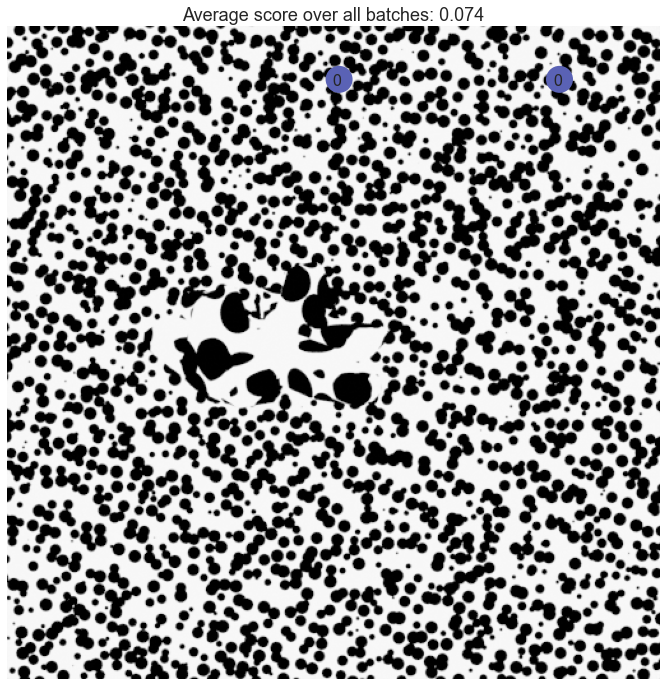

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_096.png


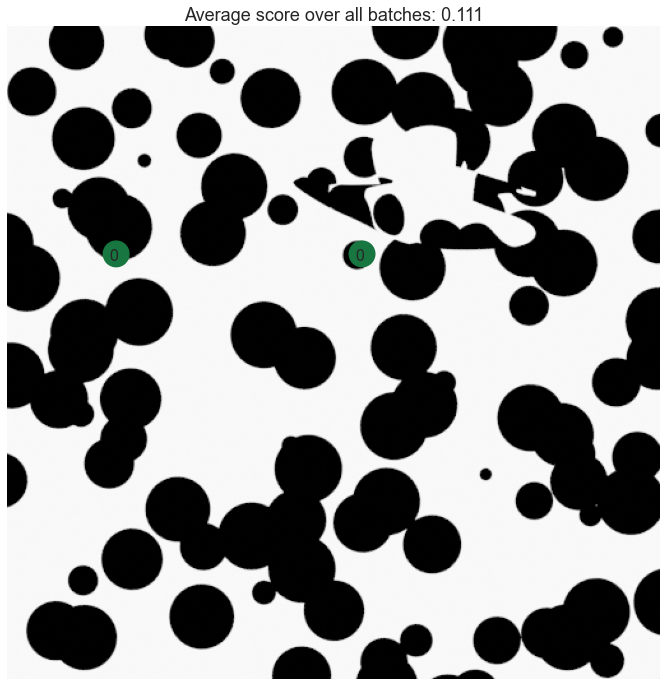

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_033.png


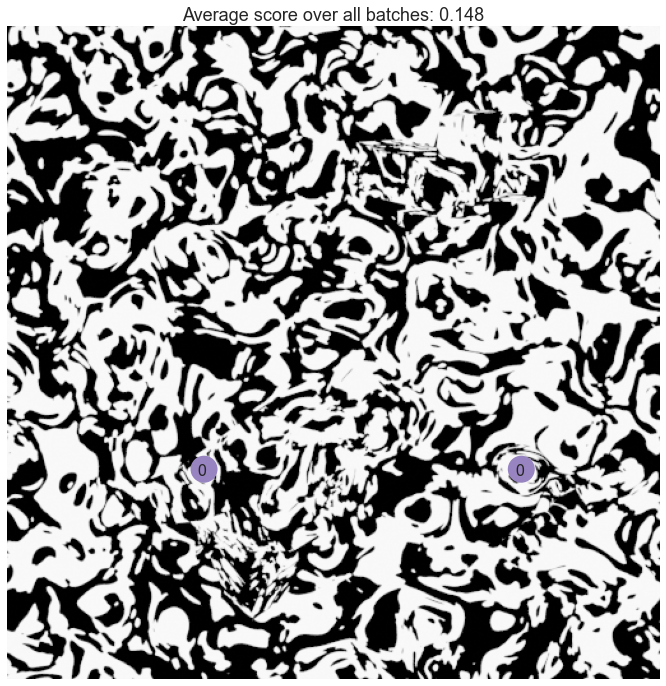

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_045.png


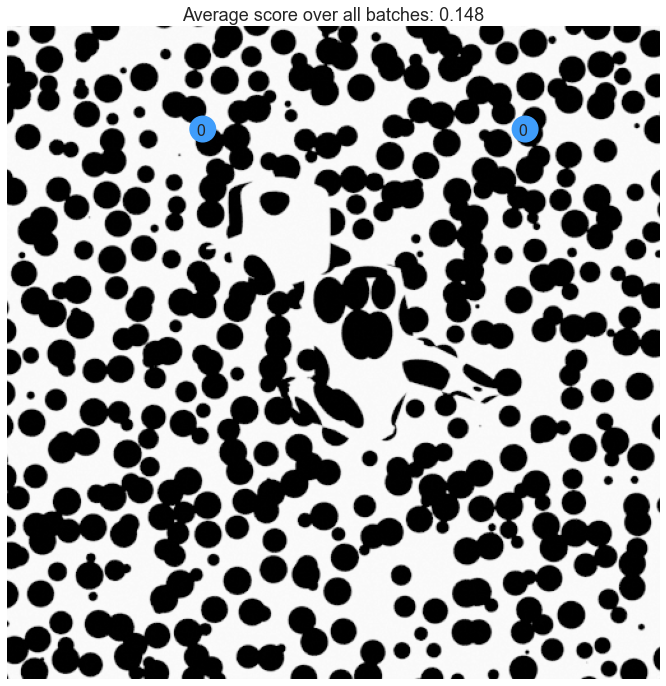

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_005.png


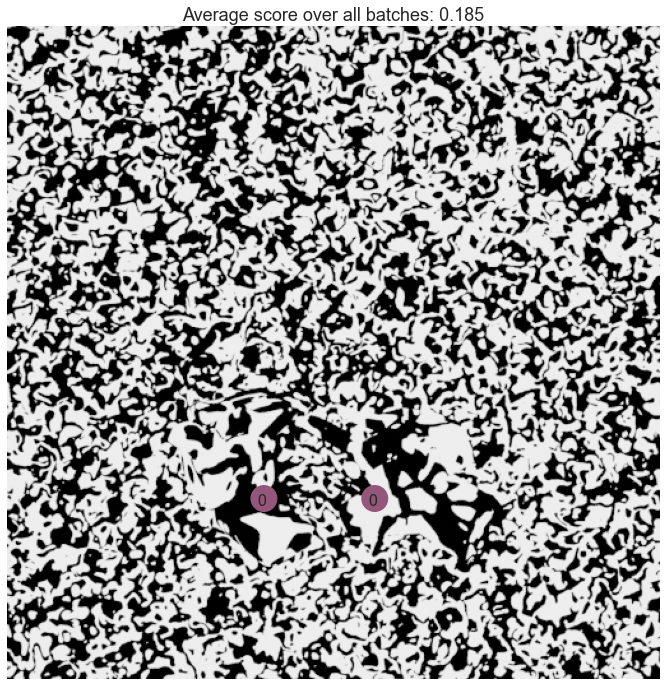

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_074.png


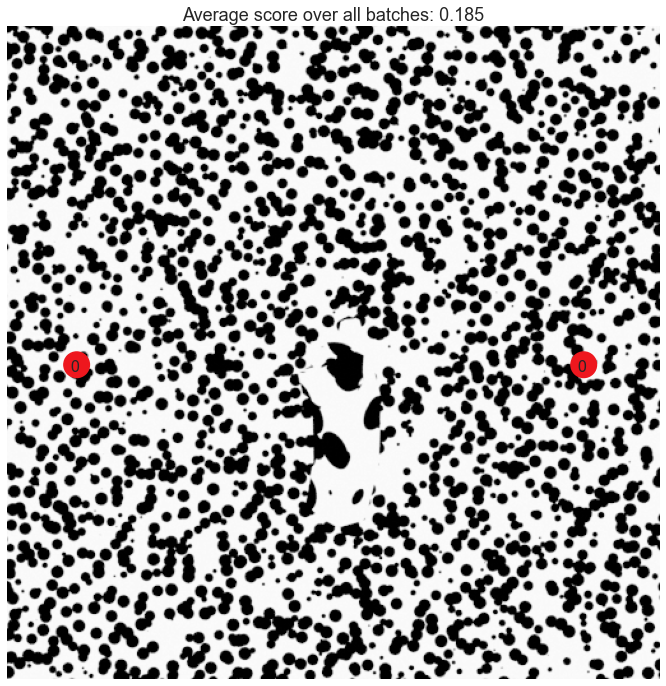

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_023.png


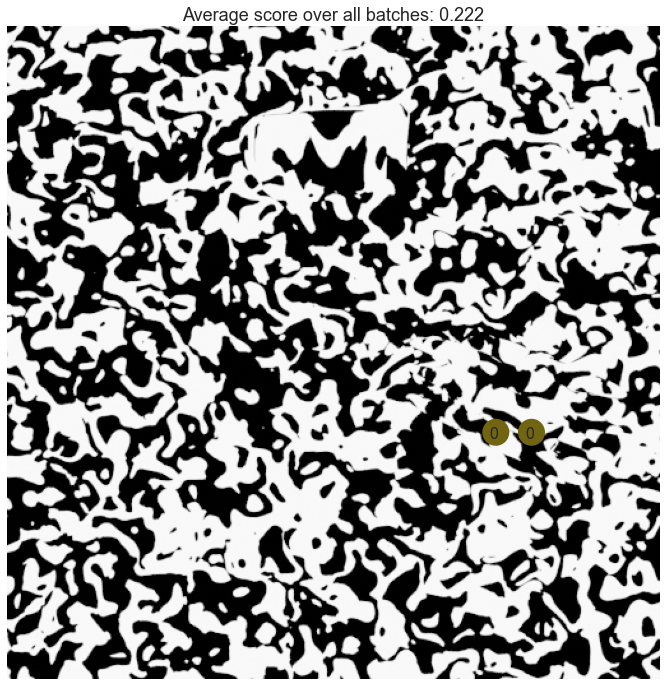

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_064.png


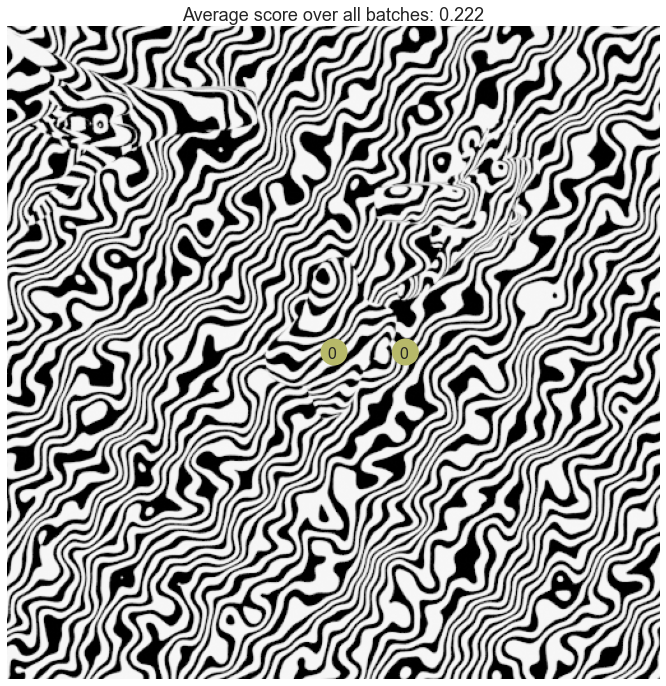

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_011.png


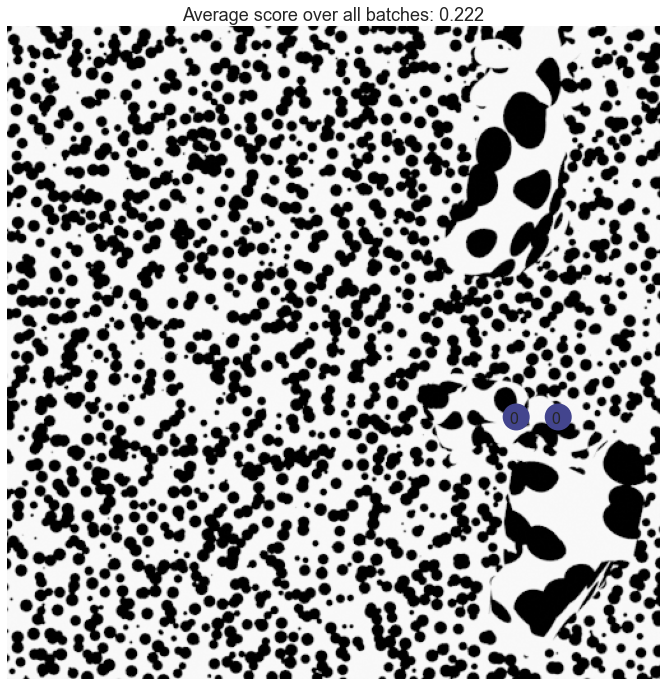

https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt_shapegen/images/image_088.png


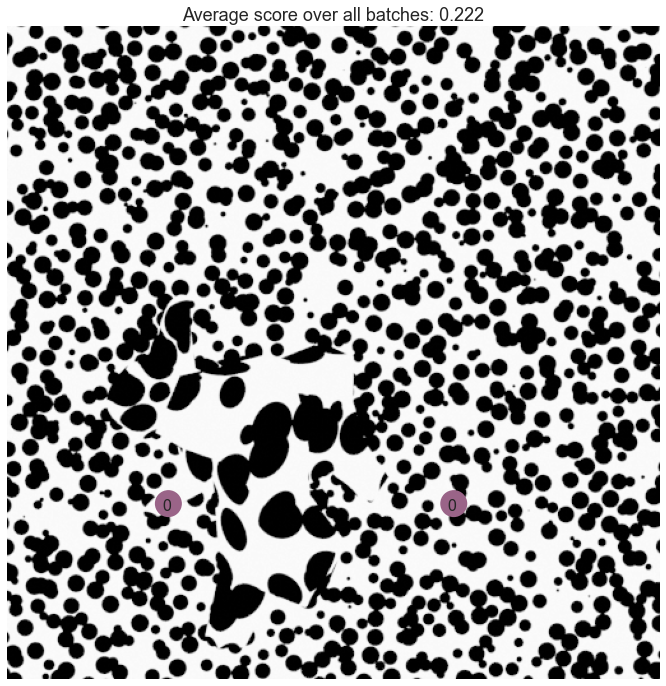

In [112]:
if dataset in SYNTHETIC_DATASETS:
    trials_ranked = df.groupby("stimulus")["correct"].mean()
    trials_ranked = trials_ranked.sort_values()
    
    for i in range(10):
        url = str(trials_ranked.index[i])
        print(url)
        img = download_from_s3(url)
        fig, ax = plt.subplots(1, 1, figsize=(12,12))
        plt.axis("off")
        ax.imshow(np.array(img), cmap="gray")
        ax = plot_probe_locations(ax, df, url)
        score = trials_ranked[i]
        
        plt.title(f"Average score over all batches: {score:0.3f}")
        plt.show()

## Check intra-user consistency

In [113]:
repeat_trials = df.loc[df["isDuplicate"] == True]

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3515 entries, 22 to 4113
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               3515 non-null   object 
 1   imageMetadata     3515 non-null   object 
 2   imageURL          3515 non-null   object 
 3   attentionCheck    3515 non-null   object 
 4   gtDepths          3515 non-null   object 
 5   correctChoice     3515 non-null   float64
 6   probeLocations    3515 non-null   object 
 7   isDuplicate       3515 non-null   object 
 8   batchIdx          3515 non-null   float64
 9   rt                3515 non-null   int64  
 10  index             3515 non-null   float64
 11  stimulus          3515 non-null   object 
 12  response          3515 non-null   object 
 13  correct           3515 non-null   object 
 14  probe_locations   3515 non-null   object 
 15  correct_choice    3515 non-null   float64
 16  choices           3515 non-null   object 

# Measurement Noise

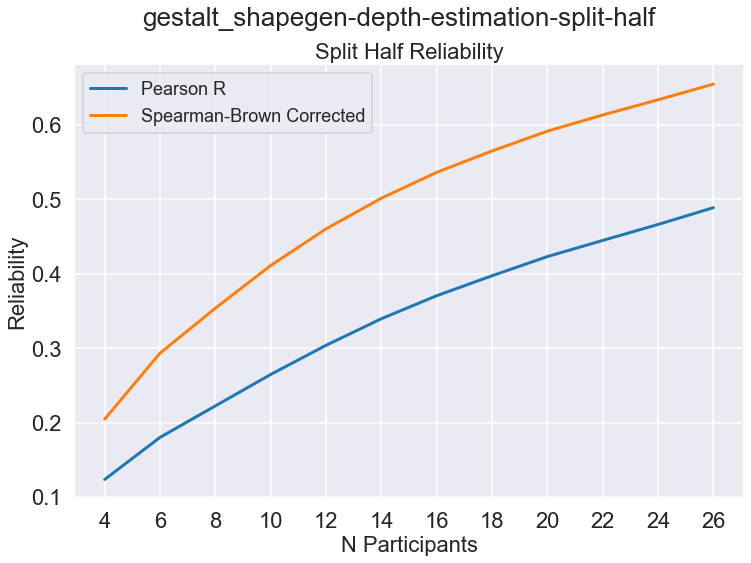

In [115]:
# Split data by user
# For each trial correlate half and half splits
from scipy.stats import pearsonr, sem

def calculate_splithalf(split_num):
    """
    split_num: int: number of participants to sample for each half (ie; if split_num is 5, you choose 5 people for group A and 5 for group B)
    """
    trials = [x[1].values[:27] for x in df.groupby("imageURL")["correct"]]
    trials = np.stack(trials, axis=0) # Gives us a (n_trials, m_participants) array of errors (in our case [100, 38])

    n_participants = trials.shape[1]
    
    pearson_rs = []
    spb_rs = [] # Spearman-Brown corrected Pearson R values
    p_vals = []

    # Take 1000 random splits of participants
    splits = 1000

    for i in range(splits):
        idxs = np.random.choice(range(n_participants), split_num * 2, replace=False)
        a_idxs, b_idxs = np.split(idxs, 2)
        
        a_errs = trials[:, a_idxs].mean(axis=1) # average errors across images
        b_errs = trials[:, b_idxs].mean(axis=1)

        stat, p_val = pearsonr(a_errs, b_errs)
        p_vals.append(p_val)
        pearson_rs.append(stat)
        
        # Spearman-Brown correction = (n*p)/(1 + (n-1)*p) 
        # For split-half n=2 tests
        spb_rs.append((2 * stat) / (1 + stat))

#     print(f"Testing split of {split_num} participants against remainder of population."\
#           f"\nR\t=\t{np.mean(reliabilities)},"\
#           f"\nStd Err\t=\t{sem(reliabilities)}"
#           f"\nP-value\t=\t{np.mean(p_vals)}")
    
    return np.mean(pearson_rs), np.mean(spb_rs)

fig = plt.figure(figsize=(12,8))
rs = []
spbs = []
nparticipants = 14
split_nums = list(range(2, nparticipants))
for split_num in split_nums:
    r, spb = calculate_splithalf(split_num)
    spbs.append(spb)
    rs.append(r)

plt.yticks(fontsize=22)
plt.xticks(range(2, nparticipants), [n * 2 for n in split_nums], fontsize=22)
plt.plot(split_nums, rs, lw=3, label="Pearson R")
plt.plot(split_nums, spbs, lw=3, label="Spearman-Brown Corrected")
plt.xlabel("N Participants", fontsize=22)
plt.ylabel("Reliability", fontsize=22)
plt.legend(fontsize=18)
plt.title("Split Half Reliability", fontsize=22)
plt.suptitle(f"{experimentName}")
plt.show()